# <!-- TITLE --> [GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init
### 1.1 - Python stuffs

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from datetime import datetime
import datetime

from importlib import reload
import math, random

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color


run_dir = './run/GTSRB3.001'
datasets_dir='fidle-datasets'

In [3]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 20
scale         = 1
fit_verbosity = 1

## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  


In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    
    # ---- Shuffle
    #x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset 
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#

def rescale_dataset(*data, scale=1):
    '''
    Rescale numpy array with 'scale' factor
    args:
        *data : arrays
        scale : scale factor
    return:
        arrays of rescaled data
    '''
    return [ d[:int(scale*len(d))] for d in data ]

# x_train,y_train, x_test,y_test = rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(1960, 24, 24, 1) (1960,)


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

In [6]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

x_train :  (1960, 24, 24, 1)
y_train :  (1960,)
x_test  :  (631, 24, 24, 1)
y_test  :  (631,)


In [7]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    
    plt.show()

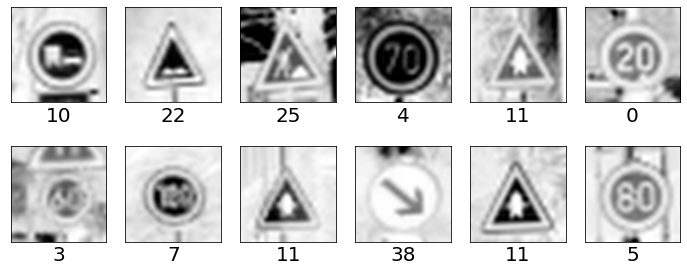

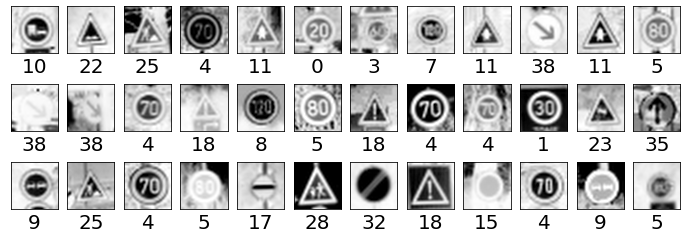

In [8]:
plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2)
plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1)

Step 4 - Create model
We will now build a model and train it...

Some models :

In [9]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [11]:
def mkdir(path):
    os.makedirs(path, mode=0o750, exist_ok=True)
def tag_now():
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

In [17]:
mkdir(run_dir + '/models')
mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir C:\Users\Massimo\projet__DS\Formation\run\GTSRB3.001\logs


## Step 6 - Train the model
**Get the shape of my data :**

In [18]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [19]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [20]:
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

Epoch 1/20
62/62 [==============================] - 7s 105ms/step - loss: 3.5231 - accuracy: 0.0633 - val_loss: 3.3988 - val_accuracy: 0.0792
Epoch 2/20
62/62 [==============================] - 6s 93ms/step - loss: 3.0803 - accuracy: 0.1964 - val_loss: 2.7329 - val_accuracy: 0.3122
Epoch 3/20
62/62 [==============================] - 6s 95ms/step - loss: 2.1249 - accuracy: 0.4378 - val_loss: 1.8057 - val_accuracy: 0.5087
Epoch 4/20
62/62 [==============================] - 6s 100ms/step - loss: 1.4411 - accuracy: 0.5857 - val_loss: 1.3885 - val_accuracy: 0.6022
Epoch 5/20
62/62 [==============================] - 6s 92ms/step - loss: 1.0978 - accuracy: 0.6612 - val_loss: 1.2115 - val_accuracy: 0.6719
Epoch 6/20
62/62 [==============================] - 6s 99ms/step - loss: 0.8123 - accuracy: 0.7571 - val_loss: 1.0154 - val_accuracy: 0.7322
Epoch 7/20
62/62 [==============================] - 6s 95ms/step - loss: 0.6422 - accuracy: 0.8107 - val_loss: 0.9684 - val_accuracy: 0.7670
Epoch 8/20


**Save model :**

In [37]:
model.save(f'{run_dir}/models/last-model.h5')

**Evaluate it :**

In [21]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.8653


In [22]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.7556
Test accuracy  : 0.8542


## Step 7 - History
The return of model.fit() returns us the learning history

In [23]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        
        plt.show()

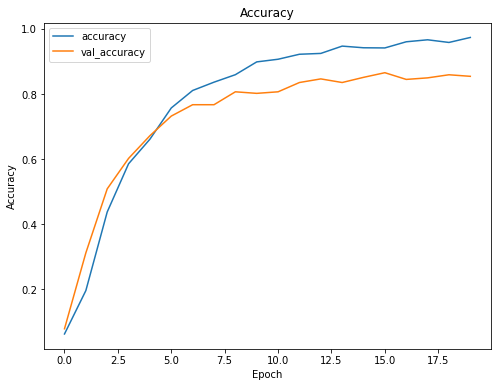

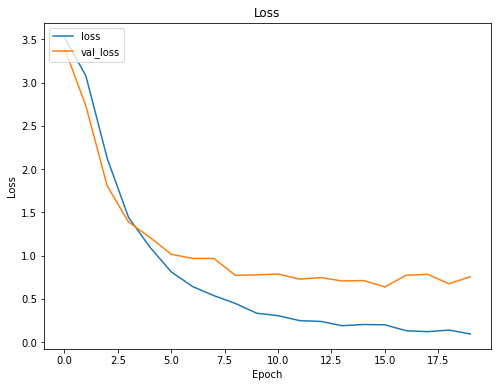

In [24]:
plot_history(history)

## Step 8 - Evaluation and confusion

In [26]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

<AxesSubplot:>

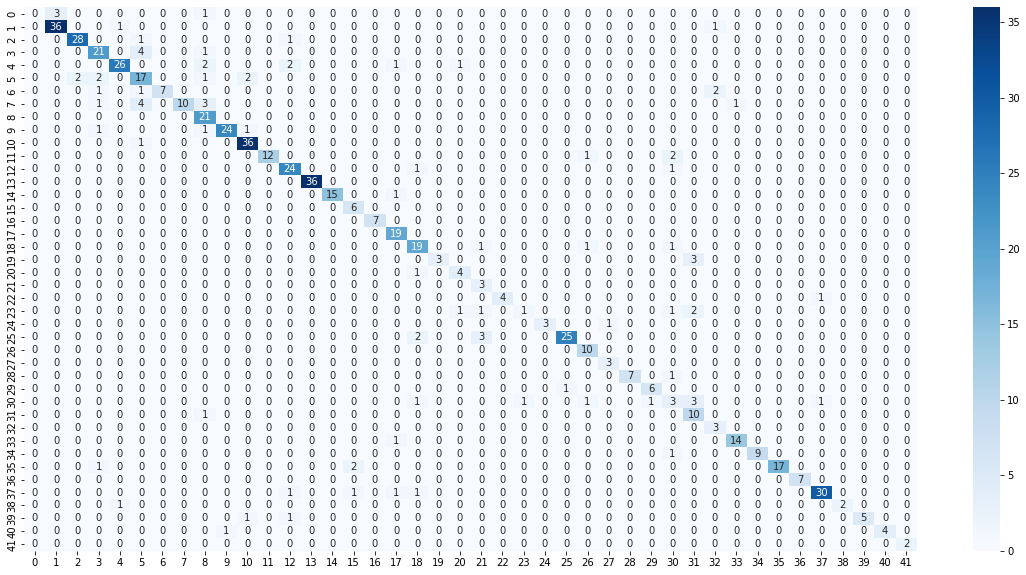

In [27]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='1', cmap='Blues')

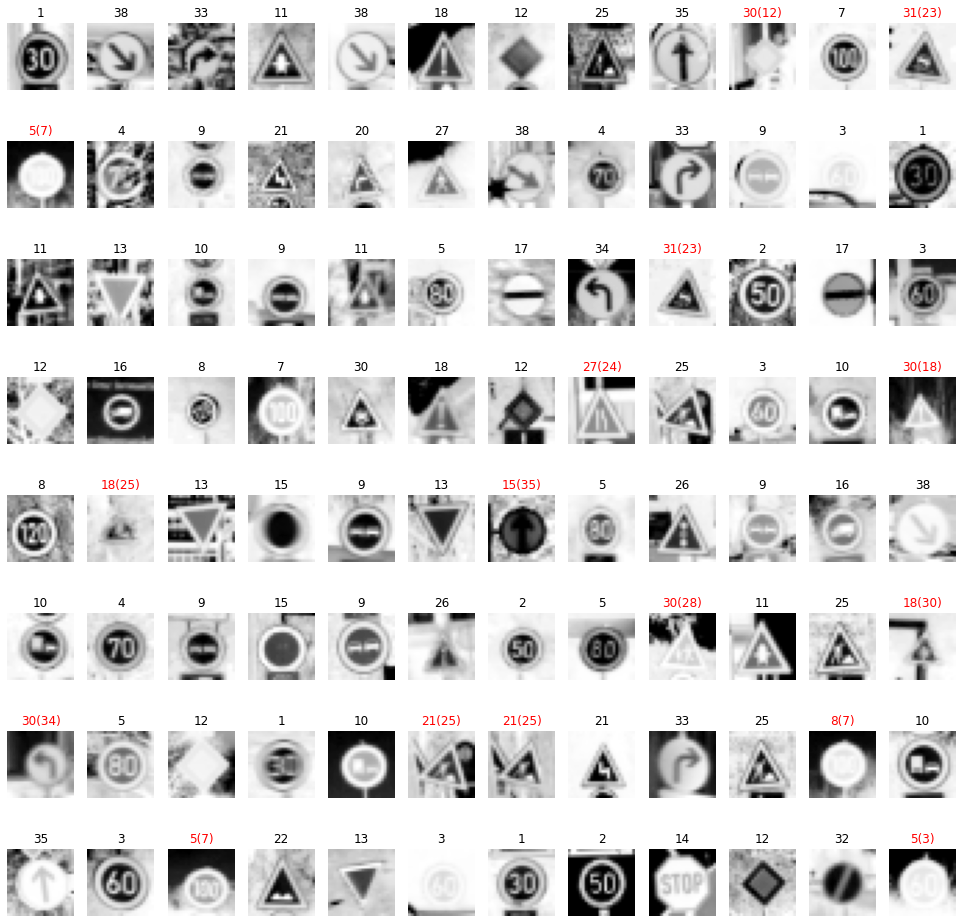

In [31]:
fig=plt.figure(figsize=(17, 17))
columns = 12
rows = 8
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[i],cmap='binary')
    plt.axis('off')
    if y_pred[i]==y_test[i]:
        plt.title(y_test[i])
    else:
        plt.title(f'{y_pred[i]}({y_test[i]})', color='r') 
plt.show()

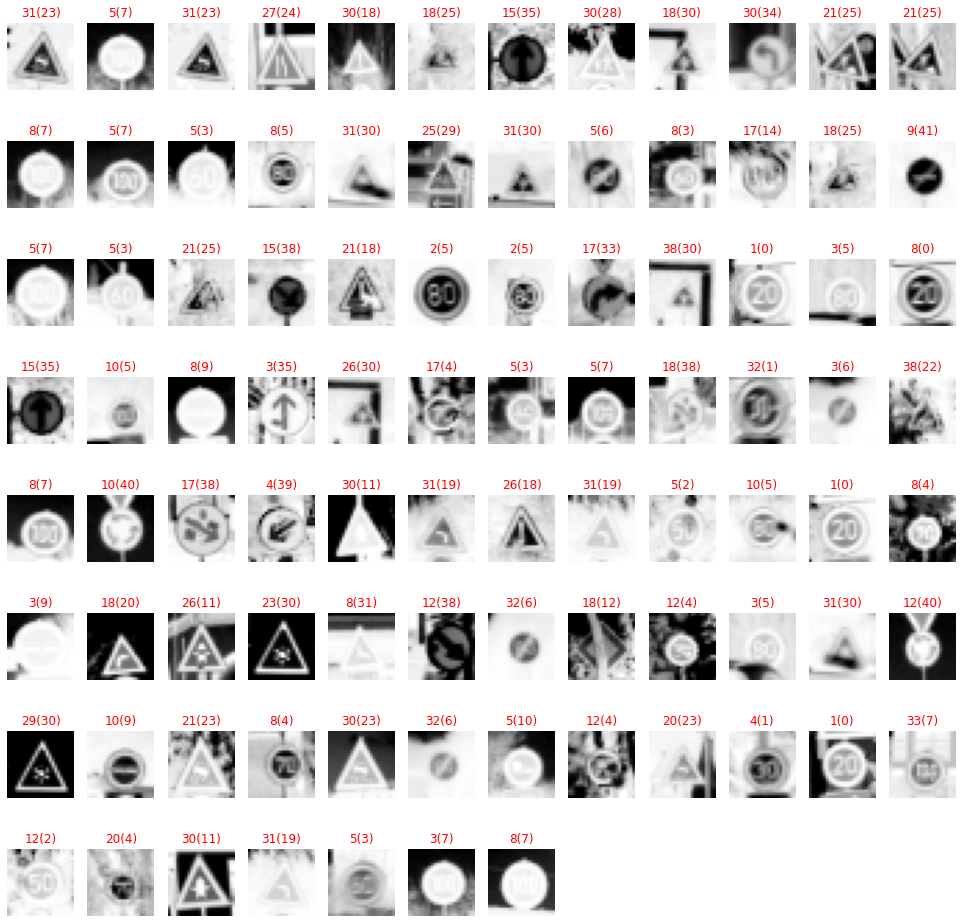

In [33]:
errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
fig=plt.figure(figsize=(17, 17))
columns = 12
rows = int(len(errors)/12)+1
for i in range(1, len(errors)):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(x_test[errors[i]],cmap='binary')
    plt.title(f'{y_pred[errors[i]]}({y_test[errors[i]]})', color='r') 
plt.show()

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [38]:
!find "$run_dir"/models/

FINDÿ: format incorrect de paramŠtre


### 9.2 - Restore a model :

In [39]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

### 9.3 - Evaluate it :

In [40]:
score = loaded_model.evaluate(x_test, y_test)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

20/20 [==============================] - 0s 17ms/step - loss: 0.7556 - accuracy: 0.8542
Test loss      : 0.7556
Test accuracy  : 0.8542


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.   30.94  0.    0.    0.    0.    0.    0.01  0.   68.64  0.41  0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

Graphically :



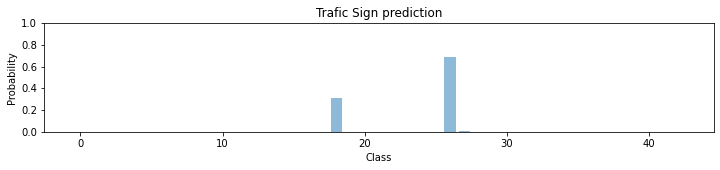


The image :               Prediction :            Real stuff:


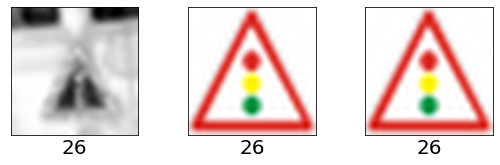

YEEES ! that's right!


In [44]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')

plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2)

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

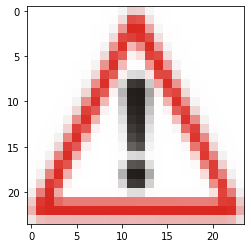

In [48]:
plt.imshow(x_meta[18])